In [10]:
from collections import Counter, defaultdict
import itertools as it
import math
from pprint import pprint

import numpy as np
# from tqdm import tqdm

try:
    from sage.geometry.lattice_polytope import LatticePolytope
except ImportError:
    pass

from orders import position_compare, tamari_compare
from posets import LowerOrderIdeal

In [ ]:
def compute_transformation(source_points, target_points):
    """"
        Computes the linear transformation that maps the source points to the target points.

        Note: The points are in sorted order so that the i-th source point is mapped to the 
        i-th target point.

        There is a closed formula for the transformation (with some assumptions):
        https://math.stackexchange.com/a/2838878
    """
    return np.inv(source_points.T @ source_points) @ (source_points.T) @ target_points

In [7]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def coplanar_faces(hull):
    coplanar_mask = np.zeros((len(hull.simplices), len(hull.simplices)), dtype=bool)
    for i, simplex in enumerate(hull.simplices):
        for j, other_simplex in enumerate(hull.simplices):
            if i != j:
                if j in hull.neighbors[i]:
                    common_indices = [idx for idx in simplex if idx in other_simplex]
                    simplex_diff_idx = list(set(simplex) - set(other_simplex))[0]
                    other_simplex_diff_idx = list(set(other_simplex) - set(simplex))[0]
                    defining_cross = np.cross(hull.points[common_indices[1]] - hull.points[common_indices[0]], hull.points[simplex_diff_idx] - hull.points[common_indices[0]])
                    coplanar_mask[i, j] = math.isclose(defining_cross.dot(hull.points[other_simplex_diff_idx] - hull.points[common_indices[0]]), 0)
                else:
                    coplanar_mask[i, j] = False
            else:
                coplanar_mask[i, j] = True
    return coplanar_mask


def facet_points(hull, coplanar_mask):
    facet_points = defaultdict(set)
    visited_simplices = set()
    for i, simplex in enumerate(hull.simplices):
        if i not in visited_simplices:
            visited_simplices.add(i)
            facet_points[i].update(simplex)
            for j, other_simplex in enumerate(hull.simplices):
                if coplanar_mask[i, j]:
                    visited_simplices.add(j)
                    facet_points[i].update(other_simplex)
    return list(map(list, facet_points.values()))


def clockwise_around_center(point, centroid, defining_cross):
    """
    
    Taken from https://stackoverflow.com/a/74413211
    """
    # make arctan2 function that returns a value from [0, 2 pi) instead of [-pi, pi)
    arctan2 = lambda s, c: angle if (angle := np.arctan2(s, c)) >= 0 else 2 * np.pi + angle
    
    diff = point - centroid
    rcos = np.dot(diff, centroid)
    rsin = np.dot(defining_cross, np.cross(diff, centroid))
    return arctan2(rsin, rcos).item()


def plot_convex_hull(hull):
    dim = hull.points.shape[1]
    if dim not in {2,3}:
        return
    points = hull.points

    fig = plt.figure()
    if dim == 2:
        ax = fig.add_subplot(111)
        hull_vertices = points[hull.vertices]
        hull_vertices = np.append(hull_vertices, [hull_vertices[0]], axis=0)
        ax.plot(hull_vertices[:, 0], hull_vertices[:, 1], 'r--')
    if dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='red')
        facets = facet_points(hull, coplanar_faces(hull))
        for facet in facets:
            # reorder to be clockwise around the centroid
            centroid = np.mean(points[facet], axis=0)
            defining_cross = np.cross(points[facet[1]] - points[facet[0]], points[facet[2]] - points[facet[0]])
            sorted_facet = sorted(facet, key=lambda idx: clockwise_around_center(points[idx], centroid, defining_cross))
            cyclic_facet = np.append(sorted_facet, sorted_facet[0])
            # plot the edges
            ax.plot(points[cyclic_facet, 0], points[cyclic_facet, 1], points[cyclic_facet, 2], 'k-')
            
            # plot the facets
            vertices = [points[facet_idx] for facet_idx in cyclic_facet]
            # vertices = [points[simplex[0]], points[simplex[1]], points[simplex[2]], points[simplex[0]]]
            mpl_facet = Poly3DCollection([vertices], alpha=0.25, facecolor='cyan')
            ax.add_collection3d(mpl_facet)
        ax.set_zlim(-0.1, dim + .1)
    ax.set_xlim(-0.1, dim + .1)
    ax.set_ylim(-0.1, dim + .1)
    plt.show()

-1z + 3 >= 0
-1y + 2 >= 0
-1x + 1 >= 0
1x >= 0
-1x + 1y >= 0
-1y + 1z >= 0
8 vertices


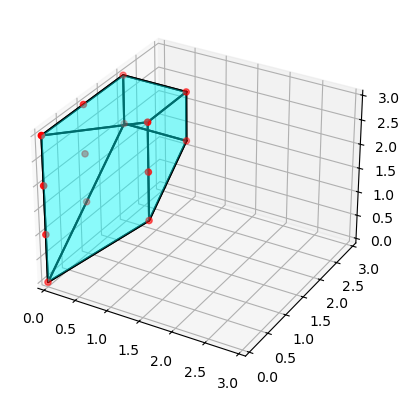

(1, 8, 12, 6, 1)



In [17]:
I = LowerOrderIdeal((1,2,3))
# I.hasse_diagram(figsize=(8,8))
hull = ConvexHull(np.array(I.nodes))
# print(f'hull.equations=\n{hull.equations}')
polytope = LatticePolytope(I.nodes)
normals, constants = polytope.facet_normals(), polytope.facet_constants()
for normal, constant in zip(normals, constants):
    dot = ' + '.join(f'{n_i}{x}' for n_i, x in zip(normal, 'xyz') if n_i != 0)
    if constant != 0:
        print(f'{dot} + {constant} >= 0')
    else:
        print(f'{dot} >= 0')

print(f'{len(polytope.vertices())} vertices')
plot_convex_hull(hull)
print(f'({", ".join(str(len(level)) for level in polytope.face_lattice().level_sets())})')
print()

-1z + 2 >= 0
-1x + 1 >= 0
-1y + 1z + 1 >= 0
1x >= 0
-1x + 1z >= 0
-1x + 1y >= 0
8 vertices


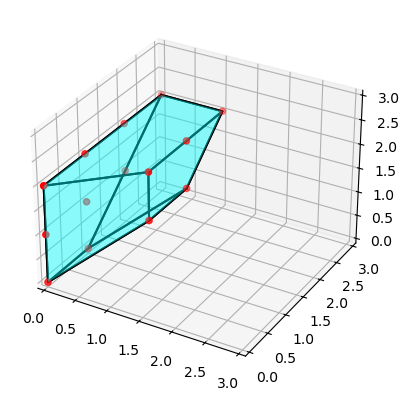

(1, 8, 12, 6, 1)



In [18]:
I = LowerOrderIdeal((1,3,2))
hull = ConvexHull(np.array(I.nodes))
# print(f'hull.equations=\n{hull.equations}')
polytope = LatticePolytope(I.nodes)
normals, constants = polytope.facet_normals(), polytope.facet_constants()
for normal, constant in zip(normals, constants):
    dot = ' + '.join(f'{n_i}{x}' for n_i, x in zip(normal, 'xyz') if n_i != 0)
    if constant != 0:
        print(f'{dot} + {constant} >= 0')
    else:
        print(f'{dot} >= 0')

print(f'{len(polytope.vertices())} vertices')
plot_convex_hull(hull)
print(f'({", ".join(str(len(level)) for level in polytope.face_lattice().level_sets())})')
print()

In [ ]:
source_points = np.array([])

In [ ]:
# print(Polyhedron(vertices=LowerOrderIdeal((3,3,3)).nodes).ehrhart_polynomial() - Polyhedron(vertices=LowerOrderIdeal((1,3,3)).nodes).ehrhart_polynomial())
# print(Polyhedron(vertices=LowerOrderIdeal((1,3,3)).nodes).ehrhart_polynomial() - Polyhedron(vertices=LowerOrderIdeal((1,2,3)).nodes).ehrhart_polynomial())
# print(Polyhedron(vertices=LowerOrderIdeal((3,3,3)).nodes).ehrhart_polynomial() - Polyhedron(vertices=LowerOrderIdeal((1,2,3)).nodes).ehrhart_polynomial())

for b in [(2,2), (1,2)]:
    I = LowerOrderIdeal(b)
    print(f'{I.root} [{len(I.nodes)} points]')
    hull = ConvexHull(np.array(I.nodes))
    # print(f'hull.equations=\n{hull.equations}')
    polytope = Polyhedron(vertices=I.nodes)
    # print(f'f polynomial: {I.f_polynomial}')
    # print(f'F polynomial: {I.F_polynomial}')
    print(f'Ehrhart polynomial: {polytope.ehrhart_polynomial()}')
    plot_convex_hull(hull)
    print()

for b in [(3,3,3), (2,3,3), (1,3,3), (1,2,3)]:
    I = LowerOrderIdeal(b)
    print(f'{I.root} [{len(I.nodes)} points]')
    hull = ConvexHull(np.array(I.nodes))
    # print(f'hull.equations=\n{hull.equations}')
    polytope = Polyhedron(vertices=I.nodes)
    # print(f'f polynomial: {I.f_polynomial}')
    # print(f'F polynomial: {I.F_polynomial}')
    print(f'Ehrhart polynomial: {polytope.ehrhart_polynomial()}')
    plot_convex_hull(hull)
    print()

# print('\n'*3)

# for b in [(4,4,4,4), (1,4,4,4), (1,2,4,4), (1,2,3,4)]:
#     I = LowerOrderIdeal(b)
#     print(f'{I.root} [{len(I.nodes)} points]')
#     hull = ConvexHull(np.array(I.nodes))
#     # print(f'{hull.equations=}')
#     polytope = Polyhedron(vertices=I.nodes)
#     # print(f'f polynomial: {I.f_polynomial}')
#     # print(f'F polynomial: {I.F_polynomial}')
#     print(f'Ehrhart polynomial: {polytope.ehrhart_polynomial()}')
#     plot_convex_hull(hull)
#     print()

# print('\n'*3)

# I = LowerOrderIdeal((1,1,1,1,1))
# polytope = Polyhedron(vertices=I.nodes)
# print(f'{I.root} [{len(I.nodes)} points]')
# print(f'{I.nodes=}')
# print(f'Ehrhart polynomial: {polytope.ehrhart_polynomial()}')
# print()

# for k, b in enumerate([(5,5,5,5,5), (1,5,5,5,5), (1,2,5,5,5), (1,2,3,5,5), (1,2,3,4,5)], start=1):
# # for k, b in enumerate([(3,3,3), (1,3,3), (1,2,3)], start=1):
#     I = LowerOrderIdeal(b)
#     print(f'{I.root} [{len(I.nodes)} points]')
#     d = len(b)
#     correction_term = sum(catalan_number(i) * binomial(2*(d-i), d-i+1) for i in range(1, k))
#     print(f'Decomposition is true?: {len(I.nodes) == (binomial(2*d, d) - correction_term)}')
    
#     hull = ConvexHull(np.array(I.nodes))
#     print(f'{hull.equations=}')
#     polytope = Polyhedron(vertices=I.nodes)
#     # print(f'f polynomial: {I.f_polynomial}')
#     # print(f'F polynomial: {I.F_polynomial}')
#     print(f'Ehrhart polynomial: {polytope.ehrhart_polynomial()}')
#     # plot_convex_hull(hull)
#     print()

In [ ]:
max_n = 7
for n in range(2, max_n+1):
    print(f'{n=}')
    for m in range(1, n):
        b_m_minus_one = binomial(2*n, n) - sum((n-k) * catalan_number(k) * catalan_number(n-k) for k in range(1, m))
        b_m = binomial(2*n, n) - sum((n-k) * catalan_number(k) * catalan_number(n-k) for k in range(1, m+1))
        b_tilde = b_m_minus_one - b_m
        print(f'[{m=}] {b_m} = {b_m_minus_one} - {b_tilde} \t {b_tilde} =?= {(n-m)*catalan_number(m)*catalan_number(n-m)}')
    print()

In [ ]:
n = 3
b = (n,n,n)
I = LowerOrderIdeal(b)

b_1 = (1,n,n)
J = LowerOrderIdeal(b_1)

b_2 = (1,2,n)
K = LowerOrderIdeal(b_2)

print(f'b = [{len(I.nodes)}] -> {I.nodes}')
print(f'b_1 = [{len(J.nodes)}] -> {J.nodes}')
print(f'b_2 = [{len(K.nodes)}] -> {K.nodes}')
print(f'b \\ b_1: {list(set(I.nodes) - set(J.nodes))}', end='\t')
print(f'[{(n-1)*catalan_number(1)*catalan_number(n-1)} = {n-1}*{catalan_number(1)}*{catalan_number(n-1)}]')
print(f'b_1 \\ b_2: {list(set(J.nodes) - set(K.nodes))}', end='\t')
print(f'[{(n-2)*catalan_number(2)*catalan_number(n-2)} = {n-2}*{catalan_number(2)}*{catalan_number(n-2)}]')

print('\n'*3)

n = 4
b = (n,n,n,n)
I = LowerOrderIdeal(b)

b_1 = (1,n,n,n)
J = LowerOrderIdeal(b_1)

b_2 = (1,2,n,n)
K = LowerOrderIdeal(b_2)

b_3 = (1,2,3,n)
L = LowerOrderIdeal(b_3)

print(f'b = [{len(I.nodes)}]')
print(f'b_1 = [{len(J.nodes)}]')
print(f'b_2 = [{len(K.nodes)}]')
print(f'b_3 = [{len(L.nodes)}]')

print()
print(f'{b_1=}')
# print(f'b - b_1: {tuple(b_i - a_i for (b_i, a_i) in zip(b, b_1))}')
b_diff = list(map(lambda a: tuple(b_i - a_i for (b_i, a_i) in zip(b, a)), set(I.nodes) - set(J.nodes)))
# print(f'{b_diff=}')
print(f'b \\ b_1: {list(set(I.nodes) - set(J.nodes))}', end='\t')
print(f'[{(n-1)*catalan_number(1)*catalan_number(n-1)} = {n-1}*{catalan_number(1)}*{catalan_number(n-1)}]')

print()
print(f'{b_2=}')
# print(f'b - b_2: {tuple(b_i - a_i for (b_i, a_i) in zip(b, b_2))}')
b_diff = list(map(lambda a: tuple(b_i - a_i for (b_i, a_i) in zip(b, a)), set(J.nodes) - set(K.nodes)))
# print(f'{b_diff=}')
print(f'b_1 \\ b_2: {list(set(J.nodes) - set(K.nodes))}', end='\t')
print(f'[{(n-2)*catalan_number(2)*catalan_number(n-2)} = {n-2}*{catalan_number(2)}*{catalan_number(n-2)}]')

print()
print(f'{b_3=}')
# print(f'b - b_3: {tuple(b_i - a_i for (b_i, a_i) in zip(b, b_3))}')
b_diff = list(map(lambda a: tuple(b_i - a_i for (b_i, a_i) in zip(b, a)), set(K.nodes) - set(L.nodes)))
# print(f'{b_diff=}')
print(f'b_2 \\ b_3: {list(set(K.nodes) - set(L.nodes))}', end='\t')
print(f'[{(n-3)*catalan_number(3)*catalan_number(n-3)} = {n-3}*{catalan_number(3)}*{catalan_number(n-3)}]')

In [ ]:
n = 5
counts = Counter(len(LowerOrderIdeal(perm).nodes) for perm in it.permutations(range(1, n+1)))
print(counts)
print(f'{min(counts)=}')

for perm in it.permutations(range(1, n+1)):
    I = LowerOrderIdeal(perm)
    if len(I.nodes) == min(counts):
        print(f'Minimal: {I.root} [{len(I.nodes)} nodes]')
        # plot the nodes as a scatter plot
        if len(I.root) == 2:
            points = np.array(I.nodes)
            hull = ConvexHull(points)
            fig = plt.figure()
            ax = fig.add_subplot()
            ax.scatter(points[:,0], points[:,1], color='red')  # Scatter plot of points
            for simplex in hull.simplices:
                ax.plot(points[simplex, 0], points[simplex, 1], 'k-')  # Plotting the convex hull
            ax.set_xlim(-0.1, 2.1)
            ax.set_ylim(-0.1, 2.1)
            plt.show()
        elif len(I.root) == 3:
            hull = ConvexHull(np.array(I.nodes))
            polytope = Polyhedron(vertices=I.nodes)
            print(f'Ehrhart polynomial: {polytope.ehrhart_polynomial()}')
            plot_convex_hull(hull)
    else:
        print(f'Non-minimal: {I.root} [{len(I.nodes)} nodes]')
        hull = ConvexHull(np.array(I.nodes))
        polytope = Polyhedron(vertices=I.nodes)
        print(f'Ehrhart polynomial: {polytope.ehrhart_polynomial()}')
        plot_convex_hull(hull)

# counts = Counter((len(LowerOrderIdeal((i,j,k)).nodes) for (i, j, k) in it.product(range(0,3), repeat=3)))
# I.hasse_diagram(nodes_as_boxes=True, figsize=(12,12), font_family='monospace', node_color=[0,0,0,0])

# Conjectures
### Conjecture 1
$f_{\bf b}(t)$ is unimodal for any non-negative integer sequence ${\bf b}$.

In [ ]:
b = (1,2,3)
I = LowerOrderIdeal(b)
f_coefficients = list(I.f_polynomial_counts.values())
print(f'{I.f_polynomial=}')
print(f'{I.F_polynomial=}')
print(f'f is unimodal:{I.is_unimodal(f_coefficients)}')

In [ ]:
G = Permutations(4)
perms_by_polys = defaultdict(list)
for perm in G:
    p = tuple(perm)
    I = LowerOrderIdeal(p)
    I_poly = I.f_polynomial
    perms_by_polys[I_poly] += [p]

In [ ]:
print(f'There are {len(perms_by_polys)} distinct polynomials.')
print()
for poly, perms in perms_by_polys.items():
    print(poly)
    for perm in perms: print(f'{perm}: {Permutation(list(perm)).descents_composition()}')
    print(f'{len(perms)} permutations in class.')
    print()

In [ ]:
# fix a permutation (p_1, ..., p_n).
# What does the f polynomial look like if I append identities to the end?
perm = (4,3,2,1)
for k in range(4, 7):
    if k > max(perm):
        perm += (k,)
    I = LowerOrderIdeal(perm)
    print(f'{perm}: f(1)={len(I)} -> f(t)={I.f_polynomial}')

In [ ]:
R.<t> = PolynomialRing(QQ)
for k in range(7):
    perm = list(range(1,5))
    perm[-1] += k
    I = LowerOrderIdeal(tuple(perm))
    print(f'{k=}: {I.f_polynomial}')

In [ ]:
R.<t> = PolynomialRing(QQ)
f = t^10 + t^9 + 2*t^8 + 3*t^7 + 5*t^6 + 5*t^5 + 7*t^4 + 7*t^3 + 6*t^2 + 4*t + 1
g = t^15 + t^14 + 3*t^13 + 5*t^12 + 9*t^11 + 13*t^10 + 19*t^9 + 24*t^8 + 29*t^7 + 31*t^6 + 29*t^5 + 25*t^4 + 18*t^3 + 11*t^2 + 5*t + 1
h = t^21 + t^20 + 3*t^19 + 5*t^18 + 10*t^17 + 15*t^16 + 26*t^15 + 36*t^14 + 52*t^13 + 66*t^12 + 82*t^11 + 93*t^10 + 101*t^9 + 101*t^8 + 96*t^7 + 83*t^6 + 66*t^5 + 48*t^4 + 30*t^3 + 16*t^2 + 6*t + 1

print(f'{factor(f)=}')
print(f'{factor(g)=}')
print(f'{factor(h)=}')

print()
print(g//f)
print(g%f)
print((g//f)*f + (g%f) == g)

print()
print(h//g)
print(h%g)
print((h//g)*g + (h%g) == h)

print()
print(h//f)
print(h%f)
print((h//f)*f + (h%f) == h)

In [ ]:
# decomposition/minimal chains
b = (3,2,1,4,5)
total = 0
for i in range(b[-1]):
    b_minus_i = tuple(max(0, bi - i) for bi in b[:-1])
    print(f'{i=}: {b_minus_i}')
    I = LowerOrderIdeal(b_minus_i)
    total += len(I)
print(f'{len(LowerOrderIdeal(b))} =?= {total}')


### Conjecture 2
For ${\bf b} \in \mathbb{N}^n$, $f_{\bf b}(t) = f_{\text{rev}({\bf b})}(t)$ where $\text{rev}({\bf b}) = (b_n, b_{n-1}, \dots, b_1)$.

In [ ]:
search_space = [(1, 5), (1, 5), (1, 5)]
for vector in tqdm(list(it.product(*(range(upper, lower-1, -1) for (lower, upper) in search_space)))):
    I, J = LowerOrderIdeal(vector), LowerOrderIdeal(tuple(reversed(vector)))
    if I.f_polynomial_counts != J.f_polynomial_counts:
        print(f'{I.root=}\t{J.root=}')
        print(f'{I.f_poly}')
        print(f'{J.f_poly}')
        break
else:
    print(f'No counterexamples in search space = {search_space}')

### Conjecture 3
$F_{\bf b}(t)$ is unimodal for any non-negative integer sequence ${\bf b}$.

In [ ]:
b = (4, 2, 1)
I = LowerOrderIdeal(b)
F_coefficients = list(I.F_polynomial_counts.values())
print(f'{I.F_polynomial=}\n{I.is_unimodal(F_coefficients)}')

### Conjecture 4
$$\min \left\{ \left\lvert {\bf b}_{↓} \right\rvert \, \colon \, {\bf b} \in \mathfrak{S}_n \right\} = C_{n+1} = \frac{1}{n+2} \binom{2n+2}{n+1}$$

In [ ]:
max_n = 5
for n in tqdm(range(1, max_n + 1)):
    size_counter = Counter(len(LowerOrderIdeal(perm)) for perm in it.permutations(range(1, n+1)))
    min_size = min(size_counter)
    catalan_number = math.comb(2*n+2, n+1) // (n+2)
    if min_size != catalan_number:
        print(f'{n=}: {min_size} != {catalan_number}')
        break
else:
    print(f'No counterexamples found up to {n=}.')

In [ ]:
G = Permutations(4)
for conj_class in G.conjugacy_classes(): print(conj_class)
for conj_class in G.conjugacy_classes():
    print(len(conj_class))

perms = list(map(tuple, G.list()))
size_counter = Counter(len(LowerOrderIdeal(perm)) for perm in perms)
print(size_counter)

# the number of different classes yielding different sizes of lower order ideals
# S_1: 1, S_2: 1, S_3: 2, S_4: 5, S_5: 16, S_6: 60, S_7: 266

# Exercises
### Exercise 1
Construct the poset $([5], \leq_{\bf a})$ where ${\bf a} = (6,1,0,2,4)$.

In [ ]:
a = (6,1,0,2,4)
order_matrix = np.array([[position_compare(i, j, a) for j in range(len(a))] for i in range(len(a))], dtype=bool)
print(order_matrix)

### Exercise 2
Let ${\bf a} = (6,1,0,2,4)$, ${\bf b} = (7,2,9,3,5)$. Determine whether ${\bf a} \leq_T {\bf b}$.

In [ ]:
a = (6, 1, 0, 2, 4)
b = (7, 2, 9, 3, 5)
print(f'{a=} <= {b=}: {tamari_compare(a, b)}')

### Exercise 3
Construct the Hasse diagrams of $(4, 2, 1)_{↓}$ and $(1, 2, 4)_{↓}$.

In [ ]:
I = LowerOrderIdeal((1,2,3))
I.hasse_diagram(nodes_as_boxes=True, figsize=(12,12), font_family='monospace', node_color=[0,0,0,0])

J = LowerOrderIdeal((3,2,1))
J.hasse_diagram(nodes_as_boxes=True)

### Exercise 4
Compute $f_{(4,2,1)}$ and $f_{(1,2,4)}$.

In [ ]:
I = LowerOrderIdeal((4,2,1))
print(f'{I.f_polynomial=}')

J = LowerOrderIdeal((1,2,4))
print(f'{J.f_polynomial=}')